In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.axes as axes
import pandas as pd
pd.set_option('display.max_rows', 40)
!date

Thu Feb 27 15:59:37 PST 2020


# 2010 census demo data. AIAN pop in urban vs rural areas: looking for the downward bias in DP counts ala Akee's findings

Akee's talk here: https://vimeo.com/380264104

In [2]:
##Encoding of the AIANHH var:
#0001–4999 Federally recognized American Indian reservation and/or off-reservation trust land
#5000–5499 Hawaiian home land 5500–5999 Oklahoma tribal statistical area
#5500–5999 Oklahoma tribal statistical area
#6000–7999 Alaska Native village statistical area
#8000–8999 Tribal designated statistical area
#9000–9499 State-recognized American Indian reservation
#9500–9998 State designated tribal statistical area 

In [3]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK']

race_cols = ['P0030005','P0060004','P0030003','P0030004'] # asian alone, aian mix, black alone, aian alone
keep_cols = location_cols + race_cols

def my_cols(x):
    if x.startswith('P001'):
        return True
    elif x.startswith(('AIAN','AITS','TTRACT','TBLGRP','UA','UR')):
        return True
    else:
        return (x in keep_cols)

In [4]:
%%time

df_dp = pd.read_csv('/home/j/temp/abie/fiftystates2010dhc.csv', usecols=my_cols)
df_dp.backup = df_dp.copy(deep=True)

<string>:2: DtypeWarning: Columns (28,32,33,47,49,50) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 8min 36s, sys: 27.2 s, total: 9min 3s
Wall time: 9min 12s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [5]:
dta_columns = [x.lower() for x in df_dp.columns] #grab col names as lowercase
dta_columns[-5:] = df_dp.columns[-5:] #coded vars are capitalized
dta_columns #check contents

['state',
 'county',
 'tract',
 'blkgrp',
 'block',
 'aianhh',
 'aianhhfp',
 'aianhhcc',
 'aitsce',
 'aits',
 'aitscc',
 'ttract',
 'ua',
 'uasc',
 'uatype',
 'ur',
 'aianhhns',
 'aitsns',
 'aianhhsc',
 'P0010001',
 'P0030003',
 'P0030004',
 'P0030005',
 'P0060004']

In [6]:
%%time

# r = pd.read_stata('/home/j/temp/abie/all50states_2010ur1_all_vars.dta', columns=dta_columns,
#                  chunksize=100_000, convert_missing=True, preserve_dtypes=False)

# df_sf = pd.DataFrame()
# for t in r:
#     print('.', flush=True, end=' ')
#     df_sf = df_sf.append(t)
# df_sf.shape

# #saved AIAN-relevant vars here; loads faster than the .dta
df_sf = pd.read_csv('/home/j/temp/beatrixh/2020_census/all50states_asian_black_aian.csv')
df_sf.backup = df_sf.copy(deep=True)

<string>:2: DtypeWarning: Columns (7,10,11,12,13) have mixed types.Specify dtype option on import or set low_memory=False.


CPU times: user 18.9 s, sys: 5.77 s, total: 24.6 s
Wall time: 24.8 s


/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if sys.path[0] == '':


In [7]:
# df_sf.to_csv(r'/home/j/temp/beatrixh/2020_census/all50states_asian_black_aian.csv', index = None, header=True)

In [9]:
df_sf.columns = [x.upper() for x in df_sf.columns]
df_sf.columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH', 'AIANHHFP',
       'AIANHHCC', 'AITSCE', 'AITS', 'AITSCC', 'TTRACT', 'UA', 'UASC',
       'UATYPE', 'UR', 'AIANHHNS', 'AITSNS', 'AIANHHSC', 'P0010001',
       'P0030003', 'P0030004', 'P0030005', 'P0060004'],
      dtype='object')

In [10]:
df_sf.UASC.unique()

array([nan, '99', '16', '##', '19', '12', '17', '15', '13', '14', 99.0,
       12.0, 13.0, 19.0, 16.0, 17.0, 15.0, 14.0, '20', '18', 18.0, 20.0,
       21.0, '21', '22', '23', 23.0, 22.0], dtype=object)

In [11]:
df_sf = df_sf.drop('UASC', axis=1)
df_dp = df_dp.drop('UASC', axis=1)

In [12]:
location_cols = ['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH', 'AITS']

In [13]:
df_sf[location_cols + ['UR','P0030005','P0010001']].columns

Index(['STATE', 'COUNTY', 'TRACT', 'BLKGRP', 'BLOCK', 'AIANHH', 'AITS', 'UR',
       'P0030005', 'P0010001'],
      dtype='object')

In [ ]:
df = pd.merge(df_sf[location_cols + ['UR','P0030005','P0010001']], df_dp[location_cols + ['UR','P0030005','P0010001']], left_on=location_cols, right_on=location_cols, suffixes=('_SF', '_DP'), how ='left')

In [ ]:
df.head

In [ ]:
left = df_sf[location_cols + race_cols + ['P0010001']]
df = pd.merge(left[(left.BLOCK != '')], df_dp.dropna(subset=['BLOCK']), left_on=location_cols, right_on=location_cols, suffixes=('_SF', '_DP'))
df

## want to check out two sets of quandrants:
# {urban aian, rural aian} x {> 99 q, < 99q} & {on-res aian, off-res aian} x {> 99 q, < 99q}

In [ ]:
# county level 
county_df = df.groupby(['STATE','COUNTY'])['P0030005_SF','P0030005_DP',
                                           'P0060004_SF','P0060004_DP',
                                           'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

In [13]:
#subset to urban areas, grouped by county
urban_county = df[df.UR== 'U'].copy(deep=True)
urban_county = #subset to rural areas, grouped by county
rural_county = df[df.UR== 'R'].copy(deep=True)
rural_county = rural_county.groupby(['STATE','COUNTY'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [14]:
#subset to rural areas, grouped by county
rural_county = df[df.UR== 'R'].copy(deep=True)
rural_county = rural_county.groupby(['STATE','COUNTY'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [17]:
#get 99th quantile
q99 = np.quantile(county_df['P0030005_SF'],.99)
q99

88698.95000000023

In [27]:
rural_above = rural_county[rural_county['P0030005_SF'] > 2]['P0030005_SF']
rural_above.shape

(3002,)

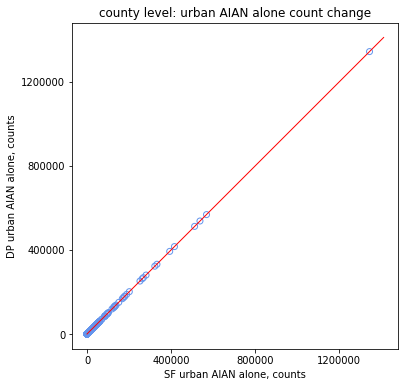

In [26]:
x = urban_county[["P0030005_SF"]]
y = urban_county[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

plt.xticks(np.arange(0, 1.4e6, step = 4e5))
plt.yticks(np.arange(0, 1.4e6, step = 4e5))

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN alone count change')

plt.show()

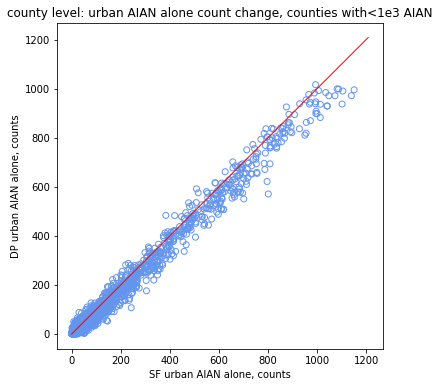

In [27]:
#let's zoom in
x = urban_county[(urban_county.P0030005_DP<1e3) | (urban_county.P0030005_SF<1e3)][["P0030005_SF"]]
y = urban_county[(urban_county.P0030005_DP<1e3) | (urban_county.P0030005_SF<1e3)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN alone count change, counties with<1e3 AIAN')

plt.show()

## vs rural

In [28]:
#subset to rural areas, grouped by county
rural_county = df[df.UR== 'R'].copy(deep=True)
rural_county = rural_county.groupby(['STATE','COUNTY'])['P0030005_SF','P0030005_DP',
                                                        'P0060004_SF','P0060004_DP',
                                                        'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

/share/code/beatrixh/miniconda/envs/beatrix/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """


In [29]:
#plot urban areas by tract, dp vs sf
x = rural_county[["P0030005_SF"]]
y = rural_county[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF rural AIAN alone, counts')
plt.ylabel('DP rural AIAN alone, counts')
plt.title('county level: rural AIAN alone count change')

plt.show()

KeyboardInterrupt: 

In [ ]:
#zooming in
x = rural_county[(rural_county.P0030005_DP<3e3) | (rural_county.P0030005_SF<3e3)][["P0030005_SF"]]
y = rural_county[(rural_county.P0030005_DP<3e3) | (rural_county.P0030005_SF<3e3)][["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF rural AIAN alone, counts')
plt.ylabel('DP rural AIAN alone, counts')
plt.title('county level: rural AIAN alone count change, counties with<3e3 AIAN')

plt.show()

## now back to urban:

In [ ]:
#check out count difference
urban_county['abs_diff'] = urban_county['P0030005_DP'] - urban_county['P0030005_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_county[(urban_county.P0030005_DP!=0) | (urban_county.P0030005_SF!=0)].abs_diff, bins = 100)

plt.title('County level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

In [ ]:
#zoom in (counts in log space)
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_county[(urban_county.P0030005_DP!=0) | (urban_county.P0030005_SF!=0)].abs_diff, bins = 100)
plt.yscale('log')

plt.title('County level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

In [ ]:
#subset to urban areas, grouped by county
urban_tract = df[df.UR== 'U'].copy(deep=True)
urban_tract = urban_tract.groupby(['STATE','COUNTY','TRACT'])['P0030005_SF','P0030005_DP',
                                                              'P0060004_SF','P0060004_DP',
                                                              'P0010001_SF','P0010001_DP'].apply(lambda x : x.astype(int).sum())

In [ ]:
#plot urban areas by tract, dp vs sf
x = urban_tract[["P0030005_SF"]]
y = urban_tract[["P0030005_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('tract level: urban AIAN alone count change')

plt.show()

In [ ]:
#check out count difference
urban_tract['abs_diff'] = urban_tract['P0030005_DP'] - urban_tract['P0030005_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_tract[(urban_tract.P0030005_DP!=0) | (urban_tract.P0030005_SF!=0)].abs_diff, bins = 100)

plt.title('Tract level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

In [ ]:
urban_county.abs_diff.describe()

In [ ]:
#zooming in (this is same as above scatter)
urban_county[(urban_county.P0030005_DP<5e2) | (urban_county.P0030005_SF<5e2)].abs_diff.describe()

In [ ]:
#zoom in (counts in log space)
urban_tract['abs_diff'] = urban_tract['P0030005_DP'] - urban_tract['P0030005_SF']

#plot histogram
fig = plt.figure()
ax = fig.add_subplot(111)
plt.hist(urban_tract[(urban_tract.P0030005_DP!=0) | (urban_tract.P0030005_SF!=0)].abs_diff, bins = 100)
plt.yscale('log')

plt.title('Tract level; urban AIAN count difference, excluding points that remained at 0.')

plt.show() 

## checkout AIAN in combo (solely AIAN + AIAN mixed individuals)

In [ ]:
#check out AIAN in combo, county level counts change
x = urban_county[["P0060004_SF"]]
y = urban_county[["P0060004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN in combo count change')

plt.show()

In [ ]:
#zooming in

#check out AIAN in combo, county level counts change
x = urban_county[(urban_county.P0060004_DP<6e4) | (urban_county.P0060004_SF<6e4)][["P0060004_SF"]]
y = urban_county[(urban_county.P0060004_DP<6e4) | (urban_county.P0060004_SF<6e4)][["P0060004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN in combo count change, for mixed counts <6e4')

plt.show()

In [ ]:
#zooming in

#check out AIAN in combo, county level counts change
x = urban_county[(urban_county.P0060004_DP<5e3) | (urban_county.P0060004_SF<5e3)][["P0060004_SF"]]
y = urban_county[(urban_county.P0060004_DP<5e3) | (urban_county.P0060004_SF<5e3)][["P0060004_DP"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')
ax.set_aspect('equal', adjustable='box')

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
lim = max(xright,ytop)
ax.plot([-1,lim],[-1,lim], 'red', linewidth=1)

xleft, xright = ax.get_xlim()
ybottom, ytop = ax.get_ylim()
ax.plot([-1,xright],[-1,ytop], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('DP urban AIAN alone, counts')
plt.title('county level: urban AIAN in combo count change, for mixed counts<2e4')

plt.show()

## View DP-SF difference as a function of AIAN count

In [ ]:
urban_county["abs_diff_aian_combo"] = urban_county["P0060004_DP"] - urban_county["P0060004_SF"]

#check out AIAN in combo, county level counts change
x = urban_county[["P0060004_SF"]]
y = urban_county[["abs_diff_aian_combo"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)

plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('change in DP count from SF')
plt.title('county level: urban AIAN in combo count change')

plt.show()

In [ ]:
#zooming in 

#check out AIAN alone, county level counts change
x = urban_county[["P0030005_SF"]]
y = urban_county[["abs_diff"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)


plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('change in DP count from SF')
plt.title('county level: urban AIAN alone count change')

plt.show()

In [ ]:
#zooming in 

#check out AIAN alone, county level counts change
x = urban_county[(urban_county.P0030005_SF<2e5)][["P0030005_SF"]]
y = urban_county[(urban_county.P0030005_SF<2e5)][["abs_diff"]]

fig = plt.figure() 
fig.set_size_inches(6,6)

ax = fig.add_subplot(111)
ax.scatter(x, y, facecolors='none', edgecolors = 'cornflowerblue')

xleft, xright = ax.get_xlim()
ax.plot([0,xright],[0,0], 'red', linewidth=1)


plt.xlabel('SF urban AIAN alone, counts')
plt.ylabel('change in DP count from SF')
plt.title('county level: urban AIAN alone count change for counties with <2e5 AIAN alone')

plt.show()

In [ ]:
#todo: you need to checkout the distribution of urban aian, and also on-res aian
#to see if it looks like what you were seeing with toy data.

In [ ]:
urban_county.size

# checkout aian urban overall distribution

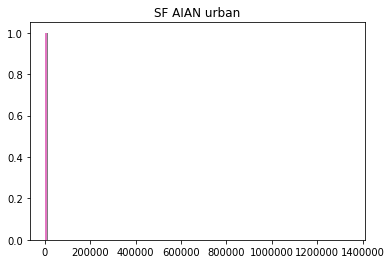

In [30]:
#check out AIAN alone, county level counts change
x = urban_county[["P0030005_SF"]]

plt.hist(x, bins = 100)
plt.title('SF AIAN urban')

plt.show()

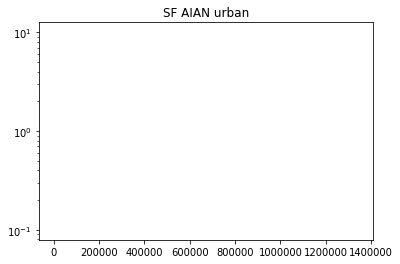

In [33]:
#check out AIAN alone, county level counts change
x = urban_county[["P0030005_SF"]]

plt.hist(x, bins = 500, log = True)
plt.title('SF AIAN urban')

plt.show()